In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, cohen_kappa_score
import torch
import sys
import torchsummary

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from models.CropTypeClassifier import *
from explainability_analysis.visualization_constants import *
from explainability_analysis.visualization_functions import *
from explainability_analysis.classification_results_summarizer import read_confusion_matrix

figures_base_path = os.path.join(FIGURES_BASE_PATH, "appendix")

NUM_CLASSES = 12
HYPERPARAMETER_TUNING_RESULTS_BASE_DIR = "C:/Users/results/{}_classes/".format(NUM_CLASSES)

def read_classification_results(classification_results_dir):
    classification_results_path = os.path.join(classification_results_dir, "predictions", "classification_metrics.csv")
    if (os.path.exists(classification_results_path)):
        classification_data = np.genfromtxt(classification_results_path, delimiter=',', skip_header = 1)
        return classification_data
    return None


def get_classification_results_per_seq_aggr_method(seq_aggr_method_dir):
    result_list = []
    seg_aggr_method = os.path.basename(seq_aggr_method_dir)
    root_result_dirs = [seq_aggr_method_dir]
    if seg_aggr_method == "sampling":
        root_result_dirs = [os.path.join(seq_aggr_method_dir, sampling_result_dir) for sampling_result_dir in os.listdir(seq_aggr_method_dir)]
    
    for root_result_dir in root_result_dirs:
        pos_enc_dirs = [os.path.join(root_result_dir, pos_enc_method) for pos_enc_method in os.listdir(root_result_dir)]
        for pos_enc_opt_dir in pos_enc_dirs:
            pos_enc_opt = os.path.basename(pos_enc_opt_dir)
            for model_config in os.listdir(pos_enc_opt_dir):
                model_result_dir = os.path.join(pos_enc_opt_dir, model_config)
                classification_results = read_classification_results(model_result_dir)
                if classification_results is not None:
                    model_hyperparameters = model_config.split(",")
                    num_layers = model_hyperparameters[0].split("=")[1]
                    num_heads = model_hyperparameters[1].split("=")[1]
                    emb_dim = model_hyperparameters[2].split("=")[1]
                    result_list.append((
                        seg_aggr_method,
                        pos_enc_opt,
                        num_layers,
                        num_heads,
                        emb_dim,
                        classification_results[1],
                        classification_results[2],
                        classification_results[6]))
    
    result_df = pd.DataFrame(result_list, 
                        columns=["SEQ_AGGR", "POS_ENC", "NUM_LAYERS", "NUM_HEADS", "EMB_DIM", "ACCURACY", "AVERAGE_CLASS_ACCURACY", "F1_SCORE"])
    result_df.sort_values(by=["F1_SCORE", "AVERAGE_CLASS_ACCURACY"], inplace=True, ascending=False)    
    return result_df


def get_parcel_region_mapping(
    root_parcel_mapping_dir = "C:/Users/Ivica Obadic/Desktop/Explainable Machine Learning in Earth Observations/Projects/EO_explainability_survey/Datasets/BavarianCrops/ids/blocks"):
    parcel_region_mapping = []
    parcel_mapping_files = [("holl", os.path.join(root_parcel_mapping_dir, "holl_test.txt")),
                            ("nowa", os.path.join(root_parcel_mapping_dir, "nowa_test.txt")),
                            ("krum", os.path.join(root_parcel_mapping_dir, "krum_test.txt"))]
    
    for region, parcel_mapping_file in parcel_mapping_files:
            with open(parcel_mapping_file, 'r') as parcel_mapping:
                parcels_for_region = [(region, int(parcel_id.strip())) for parcel_id in parcel_mapping.readlines()]
                parcel_region_mapping.extend(parcels_for_region)
    
    parcel_region_mapping_df = pd.DataFrame(parcel_region_mapping, columns = ["REGION", "PARCEL_ID"])
    return parcel_region_mapping_df

def calc_accuracy_stats_region_wise(parcel_region_mapping, model_root_path, aggregation_method):
    
    def calc_accuracy_per_region(df_region):
        accuracy = accuracy_score(df_region["LABEL"], df_region["PREDICTION"])
        f1 = f1_score(df_region["LABEL"], df_region["PREDICTION"], average="macro", zero_division=0)
        kappa = cohen_kappa_score(df_region["LABEL"], df_region["PREDICTION"])
        return pd.Series({'F1 SCORE': f1, 'AGGREGATION_METHOD': aggregation_method})
        #return pd.Series({'ACCURACY': accuracy, 'F1_SCORE': f1, 'KAPPA_SCORE': kappa, 'MODEL': aggregation_method})
    
    predictions_file = os.path.join(model_root_path, aggregation_method, "predictions", "predicted_vs_true.csv")
    predictions = pd.read_csv(predictions_file)
    predictions_with_region = pd.merge(parcel_region_mapping, predictions, on="PARCEL_ID")
    predictions_with_region = predictions_with_region.groupby("REGION").apply(calc_accuracy_per_region).reset_index()
    return predictions_with_region


def seq_aggr_strategy_comparison_plot(results_padding, results_weekly_average, results_sampling):
    all_results = pd.concat([results_padding, results_weekly_average, results_sampling])
    all_results.replace({"right_padding": "Right padding", "sampling": "Random sampling", "weekly_average": "Weekly average"}, inplace=True)
    all_results.rename(columns={"SEQ_AGGR": "SEQUENCE AGGREGATION STRATEGY", "AVERAGE_CLASS_ACCURACY": "Class accuracy", "F1_SCORE": "F1 score"}, inplace=True)
    all_results = pd.melt(all_results, id_vars=['SEQUENCE AGGREGATION STRATEGY'], value_vars=['Class accuracy', 'F1 score'], var_name="Metric", value_name="Score")
    fig_width = set_size(260)[0]
    fig, axs = plt.subplots(figsize=(fig_width, 2.5))
    boxplot = sns.boxplot(x="SEQUENCE AGGREGATION STRATEGY", y="Score",
            hue="Metric", palette=["m", "g"],
            data=all_results, ax = axs)
    boxplot.set(xlabel=None)
    fig.tight_layout()
    plt.savefig(os.path.join(figures_base_path, 'seq_aggr_comparison.pdf'), dpi=400)
    
def seq_aggr_pos_enc_strategy_comparison_plot(results_padding, results_weekly_average, results_sampling):
    all_results = pd.concat([results_padding, results_weekly_average, results_sampling])
    all_results.sort_values(by=["AVERAGE_CLASS_ACCURACY"], inplace=True, ascending=False)
    all_results.replace({"right_padding": "Right padding", "sampling": "Random sampling", "weekly_average": "Weekly average", "obs_aq_date": "Observation acquisition date", "seq_order": "Sequence order"}, inplace=True)
    all_results.rename(columns={"SEQ_AGGR": "Aggregation approach", "F1_SCORE": "F1 score", "POS_ENC": "Positional encoding"}, inplace=True)
    all_results = pd.melt(all_results, id_vars=["Aggregation approach", "Positional encoding"], value_vars=["F1 score"], var_name="METRIC", value_name="F1 score")
    
    fig, axs = plt.subplots(figsize=(7, 6))
    boxplot = sns.boxplot(x="Aggregation approach", y="F1 score",
            hue="Positional encoding", order=["Right padding", "Weekly average", "Random sampling"],
            data=all_results, ax = axs)
    boxplot.set(xlabel=None)

    plt.savefig(os.path.join(figure_results_path, 'pos_enc_comparison.eps'), dpi=400)



def hyperparams_partial_dependence_plot(results_table):
    
    seq_aggr_strategy = results_table["SEQ_AGGR"].values[0]
    avg_result_num_layers = results_table.groupby(["NUM_LAYERS"]).agg({"AVERAGE_CLASS_ACCURACY": 'mean', "F1_SCORE": "mean"})
    avg_result_num_heads = results_table.groupby(["NUM_HEADS"]).agg({"AVERAGE_CLASS_ACCURACY": 'mean', "F1_SCORE": "mean"})
    avg_result_emb_dim = results_table.groupby(["EMB_DIM"]).agg({"AVERAGE_CLASS_ACCURACY": 'mean', "F1_SCORE": "mean"})
    avg_result_emb_dim = avg_result_emb_dim.sort_index()
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 6), sharey=True)
    num_layers_dependence_plot = sns.lineplot(data=avg_result_num_layers, ax = axs[0])
    num_heads_dependence_plot = sns.lineplot(data=avg_result_num_heads, ax = axs[1])
    emb_dim_dependence_plot = sns.lineplot(data=avg_result_emb_dim, ax = axs[2])
    fig.suptitle("Partial Dependence results for the {} sequence aggregation strategy".format(seq_aggr_strategy))
    

def get_num_model_params(model_root_path, sequence_length, num_classes, pos_enc_opt, model_dim, num_layers, num_heads):
    model_root_path = os.path.join(model_root_path, "best_model.pth")
    init_model = init_model_with_hyper_params(
        sequence_length,
        num_classes,
        pos_enc_opt,
        model_dim,
        num_layers,
        num_heads,
        False)
    snapshot = torch.load(model_root_path, map_location="cpu")
    model_state = snapshot.pop('model_state', snapshot)
    init_model.load_state_dict(model_state)
    return sum(p.numel() for p in init_model.parameters() if p.requires_grad)
    

def calc_class_accuracy_diff_after_occlusion(conf_matrix_best_model, conf_matrix_model_after_occlusion):
    relevant_classes_best_model_model_idx = conf_matrix_best_model.index.isin(conf_matrix_model_after_occlusion)
    relevant_classes_accuracy_best_model = np.diag(conf_matrix_best_model)[relevant_classes_best_model_model_idx]
    relevant_classes_accuracy_diff = np.diag(conf_matrix_model_after_occlusion) - relevant_classes_accuracy_best_model
    relevant_classes_accuracy_diff_df = pd.DataFrame(data = relevant_classes_accuracy_diff, index=conf_matrix_model_after_occlusion.index, columns=["Accuracy change"])
    relevant_classes_accuracy_diff_df.index.names=["Class"]
    return relevant_classes_accuracy_diff_df.transpose()

In [3]:
seq_aggr_method = "right_padding"
results_path = os.path.join(HYPERPARAMETER_TUNING_RESULTS_BASE_DIR, seq_aggr_method)
right_padding_results = get_classification_results_per_seq_aggr_method(results_path)
right_padding_results.sort_values(by=["AVERAGE_CLASS_ACCURACY"], ascending=False)

,SEQ_AGGR,POS_ENC,NUM_LAYERS,NUM_HEADS,EMB_DIM,ACCURACY,AVERAGE_CLASS_ACCURACY,F1_SCORE
42,right_padding,seq_order,4,1,128,0.911650,0.660512,0.658944
41,right_padding,seq_order,3,4,64,0.902516,0.656136,0.646900
12,right_padding,obs_aq_date,3,1,128,0.916073,0.646682,0.664205
0,right_padding,obs_aq_date,1,1,128,0.916705,0.646532,0.670932
40,right_padding,seq_order,3,4,128,0.912339,0.641435,0.656854
14,right_padding,obs_aq_date,3,2,128,0.913718,0.640839,0.655447
24,right_padding,seq_order,1,1,128,0.915211,0.640626,0.665129
1,right_padding,obs_aq_date,1,1,64,0.912109,0.638524,0.643770
6,right_padding,obs_aq_date,2,1,128,0.917624,0.633537,0.661384
8,right_padding,obs_aq_date,2,2,128,0.917624,0.633537,0.661384


In [4]:
seq_aggr_method = "weekly_average"
results_path = os.path.join(HYPERPARAMETER_TUNING_RESULTS_BASE_DIR, seq_aggr_method)
weekly_average_results = get_classification_results_per_seq_aggr_method(results_path)
weekly_average_results
#hyperparams_partial_dependence_plot(weekly_average_results)

,SEQ_AGGR,POS_ENC,NUM_LAYERS,NUM_HEADS,EMB_DIM,ACCURACY,AVERAGE_CLASS_ACCURACY,F1_SCORE
9,weekly_average,obs_aq_date,3,1,128,0.896082,0.581060,0.596824
2,weekly_average,obs_aq_date,1,2,128,0.898495,0.576243,0.586155
5,weekly_average,obs_aq_date,1,4,64,0.898208,0.562567,0.583283
15,weekly_average,obs_aq_date,4,1,128,0.894933,0.563190,0.580733
0,weekly_average,obs_aq_date,1,1,128,0.892119,0.555111,0.578147
8,weekly_average,obs_aq_date,2,2,64,0.893325,0.560567,0.573009
11,weekly_average,obs_aq_date,3,2,128,0.892808,0.553264,0.570528
6,weekly_average,obs_aq_date,2,1,128,0.894014,0.549928,0.569392
7,weekly_average,obs_aq_date,2,1,64,0.895163,0.545063,0.566963
18,weekly_average,obs_aq_date,4,2,64,0.893325,0.557267,0.561604


In [5]:
seq_aggr_method = "sampling"
results_path = os.path.join(HYPERPARAMETER_TUNING_RESULTS_BASE_DIR, seq_aggr_method)
random_sampling_results = get_classification_results_per_seq_aggr_method(results_path)
#hyperparams_partial_dependence_plot(random_sampling_results)
averaged_sampling_results = random_sampling_results.groupby(["SEQ_AGGR", "POS_ENC", "NUM_LAYERS", "NUM_HEADS", "EMB_DIM"]).agg(["mean", "var"]).reset_index()
averaged_sampling_results.sort_values(by=[("F1_SCORE", "mean"), ("AVERAGE_CLASS_ACCURACY", "mean")], inplace=True, ascending=False)
averaged_sampling_results

SEQ_AGGR      POS_ENC NUM_LAYERS NUM_HEADS EMB_DIM  ACCURACY            \
                                                            mean       var   
8   sampling  obs_aq_date          2         2      64  0.906124  0.000016   
3   sampling  obs_aq_date          1         4     128  0.907169  0.000017   
9   sampling  obs_aq_date          2         4     128  0.906514  0.000010   
5   sampling  obs_aq_date          2         1     128  0.906905  0.000006   
11  sampling  obs_aq_date          3         1     128  0.907351  0.000004   
15  sampling  obs_aq_date          3         4     128  0.905044  0.000004   
13  sampling  obs_aq_date          3         2     128  0.905205  0.000025   
2   sampling  obs_aq_date          1         2     128  0.907820  0.000032   
0   sampling  obs_aq_date          1         1     128  0.909036  0.000003   
4   sampling  obs_aq_date          1         4      64  0.905457  0.000017   
10  sampling  obs_aq_date          2         4      64  0.902815  0.000043   
28  sampling    seq_order          2         1     128  0.901683  0.000005   
17  sampling  obs_aq_date          4         1     128  0.904573  0.000038   
21  sampling  obs_aq_date          4         4     128  0.904687  0.000016   
36  sampling    seq_order          3         2     128  0.902355  0.000009   
12  sampling  obs_aq_date          3         1      64  0.901832  0.000024   
40  sampling    seq_order          4         1     128  0.902700  0.000006   
7   sampling  obs_aq_date          2         2     128  0.904848  0.000011   
19  sampling  obs_aq_date          4         2     128  0.902792  0.000013   
32  sampling    seq_order          2         4     128  0.899954  0.000034   
30  sampling    seq_order          2         2     128  0.901792  0.000025   
22  sampling  obs_aq_date          4         4      64  0.901091  0.000007   
16  sampling  obs_aq_date          3         4      64  0.900942  0.000029   
6   sampling  obs_aq_date          2         1      64  0.902574  0.000026   
25  sampling    seq_order          1         2     128  0.902746       NaN   
26  sampling    seq_order          1         4     128  0.903102  0.000015   
38  sampling    seq_order          3         4     128  0.899380  0.000008   
14  sampling  obs_aq_date          3         2      64  0.900011  0.000007   
42  sampling    seq_order          4         2     128  0.899759  0.000010   
29  sampling    seq_order          2         1      64  0.900643  0.000017   
23  sampling    seq_order          1         1     128  0.902298  0.000014   
44  sampling    seq_order          4         4     128  0.900643  0.000009   
20  sampling  obs_aq_date          4         2      64  0.900402  0.000024   
34  sampling    seq_order          3         1     128  0.901448  0.000022   
1   sampling  obs_aq_date          1         1      64  0.903297  0.000002   
37  sampling    seq_order          3         2      64  0.898501  0.000017   
31  sampling    seq_order          2         2      64  0.898438  0.000008   
27  sampling    seq_order          1         4      64  0.897300  0.000019   
35  sampling    seq_order          3         1      64  0.896864  0.000020   
39  sampling    seq_order          3         4      64  0.897461  0.000022   
41  sampling    seq_order          4         1      64  0.897645  0.000017   
33  sampling    seq_order          2         4      64  0.896978  0.000006   
18  sampling  obs_aq_date          4         1      64  0.898840  0.000015   
43  sampling    seq_order          4         2      64  0.896737  0.000008   
24  sampling    seq_order          1         1      64  0.896243  0.000030   
45  sampling    seq_order          4         4      64  0.893569  0.000078   

   AVERAGE_CLASS_ACCURACY            F1_SCORE            
                     mean       var      mean       var  
8                0.628122  0.000276  0.640190  0.000274  
3                0.618160  0.000206  0.640032  0.000221  
9                0.617877  

In [ ]:
seq_aggr_strategy_comparison_plot(right_padding_results, weekly_average_results, random_sampling_results)

In [6]:
#confusion matrix analysis
conf_matrix_fig_width = set_size(260)[0]
conf_matrix_fig_height = 2.5

BASE_MODEL_DIR = "C:/Users/results/crop-type-classification-explainability/12_classes/right_padding/obs_aq_date/layers=1,heads=1,emb_dim=128/"
BEST_MODEL_DIR = os.path.join(BASE_MODEL_DIR, "all_dates","1654184128")
confusion_matrix_best_model = read_confusion_matrix(BEST_MODEL_DIR)

MODEL_TOP_1_KEY_DATE_DIR = os.path.join(BASE_MODEL_DIR, "1_num_dates","1666025585")
confusion_matrix_model_top_1_key_date = read_confusion_matrix(MODEL_TOP_1_KEY_DATE_DIR)

MODEL_TOP_3_KEY_DATES_DIR = os.path.join(BASE_MODEL_DIR, "3_num_dates","1666025585")
confusion_matrix_model_top_3_key_dates = read_confusion_matrix(MODEL_TOP_3_KEY_DATES_DIR)

MODEL_TOP_5_KEY_DATES_DIR = os.path.join(BASE_MODEL_DIR, "5_num_dates","1666079473")
confusion_matrix_model_top_5_key_dates = read_confusion_matrix(MODEL_TOP_5_KEY_DATES_DIR)

GRASSLAND_OCCLUSION_MODEL_DIR = "C:/Users/results/crop-type-classification-explainability/11_classes/wo_grassland"
GRASSLAND_OCCLUSION_MODEL_DIR = os.path.join(GRASSLAND_OCCLUSION_MODEL_DIR, "right_padding", "obs_aq_date", "layers=1,heads=1,emb_dim=128", "all_dates","1654256822")
confusion_matrix_grassland_occlusion = read_confusion_matrix(GRASSLAND_OCCLUSION_MODEL_DIR)

WINTER_BARLEY_OCCLUSION_MODEL_DIR = "C:/Users/results/crop-type-classification-explainability/11_classes/wo_winter barley"
WINTER_BARLEY_OCCLUSION_MODEL_DIR = os.path.join(WINTER_BARLEY_OCCLUSION_MODEL_DIR, "right_padding", "obs_aq_date", "layers=1,heads=1,emb_dim=128", "all_dates","1654772571")
confusion_matrix_winter_barley_occlusion = read_confusion_matrix(WINTER_BARLEY_OCCLUSION_MODEL_DIR)

CORN_OCCLUSION_MODEL_DIR = "C:/Users/results/crop-type-classification-explainability/11_classes/wo_corn"
CORN_OCCLUSION_MODEL_DIR = os.path.join(CORN_OCCLUSION_MODEL_DIR, "right_padding", "obs_aq_date", "layers=1,heads=1,emb_dim=128", "all_dates","1654256851")
confusion_matrix_corn_occlusion = read_confusion_matrix(CORN_OCCLUSION_MODEL_DIR)

C:\Users\Ivica Obadic\PycharmProjects\EOExplainability\explainability_analysis\classification_results_summarizer.py:34: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  confusion_matrix_normalized = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
C:\Users\Ivica Obadic\PycharmProjects\EOExplainability\explainability_analysis\classification_results_summarizer.py:34: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  confusion_matrix_normalized = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
C:\Users\Ivica Obadic\PycharmProjects\EOExplainability\explainability_analysis\classification_results_summarizer.py:34: FutureWarning: Support for multi-dimensional indexing 

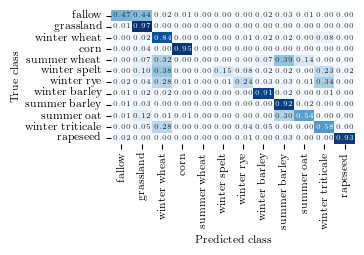

In [8]:
confusion_matrix_fonts = {
    #source: https://jwalton.info/Embed-Publication-Matplotlib-Latex/
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 8,
    "axes.titlesize": 10,
    "font.size": 5,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}
plt.rcParams.update(confusion_matrix_fonts)
fig, axs = plt.subplots(ncols=1, figsize=(conf_matrix_fig_width, conf_matrix_fig_height))

cmn_plot = sns.heatmap(confusion_matrix_best_model, annot=True, cmap="Blues", cbar=None, fmt='.2f')
cmn_plot.set_xlabel("Predicted class")

fig.tight_layout()
plt.savefig(os.path.join(figures_base_path, 'conf_matr_best_model.png'))

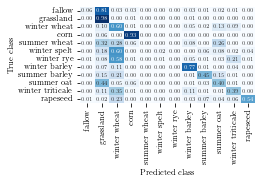

In [11]:
fig, axs = plt.subplots(ncols=1, figsize=(conf_matrix_fig_width, conf_matrix_fig_height))

cmn_plot = sns.heatmap(confusion_matrix_model_top_1_key_date, annot=True, cmap="Blues", cbar=None, fmt='.2f')
cmn_plot.set_xlabel("Predicted class")

fig.tight_layout()
plt.savefig(os.path.join(figures_base_path, 'conf_matr_1_num_dates.pdf'))

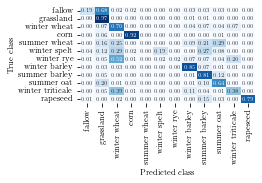

In [13]:
fig, axs = plt.subplots(ncols=1, figsize=(conf_matrix_fig_width, conf_matrix_fig_height))

cmn_plot = sns.heatmap(confusion_matrix_model_top_3_key_dates, annot=True, cmap="Blues", cbar=None, fmt='.2f')
cmn_plot.set_xlabel("Predicted class")

fig.tight_layout()
plt.savefig(os.path.join(figures_base_path, 'conf_matr_3_num_dates.pdf'))

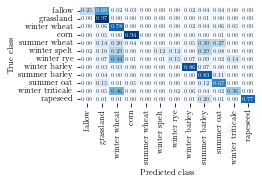

In [14]:
fig, axs = plt.subplots(ncols=1, figsize=(conf_matrix_fig_width, conf_matrix_fig_height))

cmn_plot = sns.heatmap(confusion_matrix_model_top_5_key_dates, annot=True, cmap="Blues", cbar=None, fmt='.2f')
cmn_plot.set_xlabel("Predicted class")

fig.tight_layout()
plt.savefig(os.path.join(figures_base_path, 'conf_matr_5_num_dates.pdf'))

In [ ]:
fig, axs = plt.subplots(ncols=1, figsize=(conf_matrix_fig_width, conf_matrix_fig_height))

cmn_plot = sns.heatmap(confusion_matrix_winter_barley_occlusion, annot=True, cmap="Blues", cbar=None, fmt='.2f')
cmn_plot.set_xlabel("Predicted class")

fig.tight_layout()
plt.savefig(os.path.join(figures_base_path, 'conf_matr_winter_barley_occlusion.pdf'))

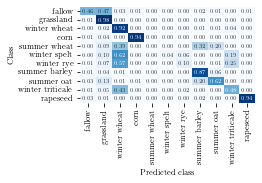

In [29]:
fig, axs = plt.subplots(ncols=1, figsize=(conf_matrix_fig_width, conf_matrix_fig_height))

cmn_plot = sns.heatmap(confusion_matrix_winter_barley_occlusion, annot=True, cmap="Blues", cbar=None, fmt='.2f')
cmn_plot.set_xlabel("Predicted class")

fig.tight_layout()
plt.savefig(os.path.join(figures_base_path, 'conf_matr_winter_barley_occlusion.pdf'))

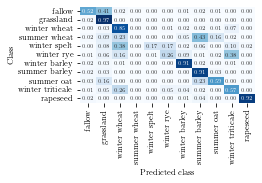

In [30]:
fig, axs = plt.subplots(ncols=1, figsize=(conf_matrix_fig_width, conf_matrix_fig_height))

cmn_plot = sns.heatmap(confusion_matrix_corn_occlusion, annot=True, cmap="Blues", cbar=None, fmt='.2f')
cmn_plot.set_xlabel("Predicted class")

fig.tight_layout()
plt.savefig(os.path.join(figures_base_path, 'conf_matr_corn_occlusion.pdf'))

In [16]:
class_accuracy_diff_grassland_occlusion = calc_class_accuracy_diff_after_occlusion(confusion_matrix_best_model, confusion_matrix_grassland_occlusion)
class_accuracy_diff_winter_barley_occlusion = calc_class_accuracy_diff_after_occlusion(confusion_matrix_best_model, confusion_matrix_winter_barley_occlusion)
class_accuracy_diff_corn_occlusion = calc_class_accuracy_diff_after_occlusion(confusion_matrix_best_model, confusion_matrix_corn_occlusion)

In [18]:
max_values = [class_accuracy_diff_grassland_occlusion.max(axis=1).item(),
              class_accuracy_diff_winter_barley_occlusion.max(axis=1).item(),
              class_accuracy_diff_corn_occlusion.max(axis=1).item()]
max_cmap_value = max(max_values)

min_values = [class_accuracy_diff_grassland_occlusion.min(axis=1).item(),
              class_accuracy_diff_winter_barley_occlusion.min(axis=1).item(),
              class_accuracy_diff_corn_occlusion.min(axis=1).item()]
min_cmap_value = min(min_values)

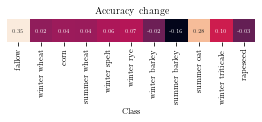

In [20]:
fig, axs = plt.subplots(ncols=1, figsize=(conf_matrix_fig_width, 1.5))

cmn_plot = sns.heatmap(class_accuracy_diff_grassland_occlusion, annot=True, vmin=min_cmap_value, vmax=max_cmap_value,  cbar=None, fmt='.2f', square=True, yticklabels=False)
axs.set_title("Accuracy change")
fig.tight_layout()
plt.savefig(os.path.join(figures_base_path, 'accuracy_change_grassland_occlusion.pdf'))

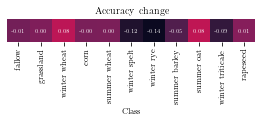

In [40]:
fig, axs = plt.subplots(ncols=1, figsize=(conf_matrix_fig_width, 1.5))

cmn_plot = sns.heatmap(class_accuracy_diff_winter_barley_occlusion, annot=True, vmin=min_cmap_value, vmax=max_cmap_value, cbar=None, fmt='.2f', square=True, yticklabels=False)
axs.set_title("Accuracy change")
fig.tight_layout()
plt.savefig(os.path.join(figures_base_path, 'accuracy_change_winter_barley_occlusion.pdf'))

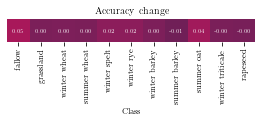

In [41]:
fig, axs = plt.subplots(ncols=1, figsize=(conf_matrix_fig_width, 1.5))

cmn_plot = sns.heatmap(class_accuracy_diff_corn_occlusion, annot=True, vmin=min_cmap_value, vmax=max_cmap_value, cbar=None, fmt='.2f', square=True, yticklabels=False)
axs.set_title("Accuracy change")
fig.tight_layout()
plt.savefig(os.path.join(figures_base_path, 'accuracy_change_corn_occlusion.pdf'))